# Домашнее задание 2. Модели предсказания

## Цель работы

Приобрести опыт решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания, посредством языка программирования Python.

## Вариант

In [1]:
surname = "Каташинский"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 55,  1, 44, 26, 18, 3, 38, 26, 18, 12,  3, 49, 45,
        7, 42, 9,  4,  3, 36, 33, 31, 29,  5, 4,  4, 19, 21, 27, 33]

d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 40 + 1

print("Задание № 2. Вариант: ", variant % 2 + 1)
print("Задание № 3. Вариант: ", variant % 3 + 1)

Задание № 2. Вариант:  1
Задание № 3. Вариант:  2


## Задача 1. Реализация собственных классов и функций

In [2]:
# Подключаем необходимые библиотеки
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [3]:
# Определяем класс оценки параметров линейной регрессии с регуляризацией
class MyLinearRegression(BaseEstimator):    
    def __init__(self, alpha):
        self.alpha = alpha
        self.weights = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X_modified = np.hstack((np.ones((n_samples, 1)), X))

        val_1 = X_modified.T.dot(X_modified)
        val_2 = self.alpha * np.eye(n_features+1)
        self.weights = np.linalg.inv(val_1 + val_2).dot(X_modified.T).dot(y)
        return self

    def predict(self, X):
        if self.weights is None:
            return

        n_samples, _ = X.shape
        X_modified = np.hstack((np.ones((n_samples, 1)), X))
        return X_modified.dot(self.weights)


# Определяем класс стандартизации признаков в виде трансформации
class MyTransformer(TransformerMixin, BaseEstimator):    
    def __init__(self, has_bias, apply_mean):
        self.has_bias = has_bias
        self.apply_mean = apply_mean
        self.mean = None
        self.std = None
    
    def fit(self, X, y=None):
        _, n_features = X.shape
        self.mean = np.zeros(n_features)
        if self.has_bias:
            self.mean = np.mean(X, axis=0)

        X_centered = X
        if self.apply_mean:
            X_centered = X - self.mean

        self.std = np.std(X_centered, axis=0)
        return self
    
    def transform(self, X, y=None):
        if (self.mean is None or
            self.std is None):
            return
        
        X_transformed = X
        if self.has_bias:
            X_transformed = X - self.mean
            
        if self.apply_mean:
            std_copied = self.std.copy()
            std_copied[std_copied == 0] = 1

            return X_transformed / std_copied
    
        val = np.sqrt(np.sum(X_transformed**2, axis=0))
        return X_transformed / val

In [4]:
# Определяем функцию разделения данных
def my_train_test_split(X, y, train_size, random_state):
    n_samples, n_features = X.shape
    if n_samples != len(y):
        return [None] * 4

    # Инициализируем списки для сохранения результатов
    X_train = X.copy()
    y_train = y.copy()
    X_test = np.empty((0, n_features))
    y_test = np.empty(0)

    # Настраиваем генератор случайных чисел
    np.random.seed(random_state)

    # Разделяем данные по условию
    while len(y_test) / len(y) < (1 - train_size):
        # Получаем элементы
        idx = np.random.choice(len(y_train))
        X_val, y_val = X_train[idx], y_train[idx]

        # Добавляем элементы к тестовой выборке
        X_test = np.append(X_test, [X_val], axis=0)
        y_test = np.append(y_test, y_val)

        # Удаляем элементы из обучающей выборки
        X_train = np.delete(X_train, idx, axis=0)
        y_train = np.delete(y_train, idx)

    return X_train, X_test, y_train, y_test


# Определяем функцию вычисления MSE
def my_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


# Определяем функцию вычсления R^2
def my_r2_score(y_true, y_pred):
    val_1 = np.sum((y_true - y_pred)**2)
    val_2 = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (val_1 / val_2)


# Определяем функцию расчета значений при отложенной выборке
def run_holdout(model, X, y, train_size, random_state) -> dict:
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = my_train_test_split(
        X, y,
        train_size=train_size,
        random_state=random_state
    )
    
    # Обучаем модель
    model.fit(X_train, y_train)
    
    # Прогнозируем результаты
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Вычисляем оценки качества
    return {
        'train': {
            'MSE': my_mean_squared_error(y_train, y_train_pred),
            'R^2': my_r2_score(y_train, y_train_pred)
        },
        'test': {
            'MSE': my_mean_squared_error(y_test, y_test_pred),
            'R^2': my_r2_score(y_test, y_test_pred)
        }
    }


# Определяем функцию расчета значений при кросс-валидации
def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict:
    # Создаем хэш для хранения оценок качества
    scores = {
        'train': {
            'MSE': [],
            'R^2': []
        },
        'test': {
            'MSE': [],
            'R^2': []
        }
    }

    # Создаем фолды и проходим по каждому из них
    kf = KFold(
        n_splits=n_splits,
        shuffle=shuffle, random_state=random_state
    )
    for train_idx, test_idx in kf.split(X):
        # Разделяем данные на обучающую и тестовую выборки
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Обучаем модель
        model.fit(X_train, y_train)

        # Прогнозируем результаты
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Вычисляем оценки качества
        scores['train']['MSE'].append(
            my_mean_squared_error(y_train, y_train_pred)
        )
        scores['test']['MSE'].append(
            my_mean_squared_error(y_test, y_test_pred)
        )
        scores['train']['R^2'].append(
            my_r2_score(y_train, y_train_pred)
        )
        scores['test']['R^2'].append(
            my_r2_score(y_test, y_test_pred)
        )

    # Вычисляем средние оценки качества
    scores['train']['MSE'] = np.mean(
        scores['train']['MSE']
    )
    scores['test']['MSE'] = np.mean(
        scores['test']['MSE']
    )
    scores['train']['R^2'] = np.mean(
        scores['train']['R^2']
    )
    scores['test']['R^2'] = np.mean(
        scores['test']['R^2']
    )

    return scores

In [5]:
# Определяем параметры модели
train_size = 0.75
n_splits = 4
shuffle = True
random_state = 0


# Определяем функцию вывода значений при отложенной выборке
def print_holdout_scores(model):
    scores_holdout = run_holdout(
        model, X, y,
        train_size, random_state
    )

    # Выводим значения MSE
    train_mse = scores_holdout['train']['MSE'].round(3)
    test_mse = scores_holdout['test']['MSE'].round(3)
    print(f'MSE: обучение={train_mse}, тест={test_mse}')

    # Выводим значения R^2
    train_r_2 = scores_holdout['train']['R^2'].round(3)
    test_r_2 = scores_holdout['test']['R^2'].round(3)
    print(f'R^2: обучение={train_r_2}, тест={test_r_2}')


# Определяем функцию вывода значений при кросс-валидации
def print_cross_val_scores(model):
    scores_cross_val = run_cross_val(
        model, X, y,
        n_splits, shuffle, random_state
    )

    # Выводим значения MSE
    train_mse = scores_cross_val['train']['MSE'].round(3)
    test_mse = scores_cross_val['test']['MSE'].round(3)
    print(f'MSE: обучение={train_mse}, тест={test_mse}')

    # Выводим значения R^2
    train_r_2 = scores_cross_val['train']['R^2'].round(3)
    test_r_2 = scores_cross_val['test']['R^2'].round(3)
    print(f'R^2: обучение={train_r_2}, тест={test_r_2}')

In [6]:
# Создаем датафрейм и выводим его вершину
df = pd.read_csv(
    '../data/A2_Model_Selection/regularization.csv'
)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,Y
0,3.856603,14.873388,57.360757,221.217682,853.148822,3290.256492,1.268921e+04,4.893726e+04,1.887316e+05,7.278629e+05,2.807078e+06,1.082579e+07,4.175077e+07,1.610161e+08,6.209754e+08,2.394856e+09,9.209759
1,0.103760,0.010766,0.001117,0.000116,0.000012,0.000001,1.294799e-07,1.343480e-08,1.393992e-09,1.446402e-10,1.500783e-11,1.557209e-12,1.615756e-13,1.676504e-14,1.739537e-15,1.804939e-16,10.409240
2,3.168241,10.037752,31.802020,100.756468,319.220791,1011.368453,3.204259e+03,1.015187e+04,3.216356e+04,1.019019e+05,3.228498e+05,1.022866e+06,3.240687e+06,1.026728e+07,3.252921e+07,1.030604e+08,7.643742
3,3.744019,14.017681,52.482471,196.495391,735.682558,2754.409777,1.031256e+04,3.861044e+04,1.445582e+05,5.412288e+05,2.026371e+06,7.586773e+06,2.840503e+07,1.063490e+08,3.981726e+08,1.490766e+09,8.453341
4,2.492535,6.212731,15.485450,38.598027,96.206935,239.799159,5.977078e+02,1.489808e+03,3.713398e+03,9.255774e+03,2.307034e+04,5.750364e+04,1.433298e+05,3.572546e+05,8.904697e+05,2.219527e+06,9.317824


In [7]:
# Создаем матрицу признаков и вектор целевых значений
X = df.filter(regex='X').values
y = df['Y'].values

In [8]:
# Создаем конвейер и обучаем его
pipeline_0 = Pipeline([
    (
        'transformer',
        MyTransformer(has_bias=True, apply_mean=True)
    ),
    (
        'regression',
        MyLinearRegression(alpha=0)
    )
])
pipeline_0.fit(X, y)

# Выводим параметры конвейера
pipeline_0.named_steps['regression'].weights

array([ 9.44892102e+00,  5.45392552e+00, -8.39975877e+01,  3.49956686e+02,
        1.53184551e+03, -1.83070401e+04,  6.48799389e+04, -1.03025276e+05,
        5.30932299e+04,  1.86181926e+03,  1.46293123e+05, -2.95060698e+05,
       -3.72080044e+04,  6.14141252e+05, -7.13734439e+05,  3.51599853e+05,
       -6.63371387e+04])

In [9]:
# Выводим значения MSE и R^2
print('Отложенная выборка')
print_holdout_scores(pipeline_0)
print()
print('Кросс-валидация')
print_cross_val_scores(pipeline_0)

Отложенная выборка
MSE: обучение=0.319, тест=0.236
R^2: обучение=0.574, тест=0.614

Кросс-валидация
MSE: обучение=0.276, тест=0.358
R^2: обучение=0.618, тест=0.499


In [10]:
# Создаем конвейер и обучаем его
pipeline_001 = Pipeline([
    (
        'transformer',
        MyTransformer(has_bias=True, apply_mean=True)
    ),
    (
        'regression',
        MyLinearRegression(alpha=0.01)
    )
])
pipeline_001.fit(X, y)

# Выводим параметры конвейера
pipeline_001.named_steps['regression'].weights

array([ 9.44860607,  0.73224081, -1.9371805 , -2.05758835,  0.04016091,
        1.50257224,  1.75576136,  1.24991695,  0.50482578, -0.15904122,
       -0.60740753, -0.81643159, -0.80818521, -0.61145388, -0.24338778,
        0.29569117,  1.0206136 ])

In [11]:
# Выводим значения MSE и R^2
print('Отложенная выборка')
print_holdout_scores(pipeline_001)
print()
print('Кросс-валидация')
print_cross_val_scores(pipeline_001)

Отложенная выборка
MSE: обучение=0.244, тест=0.175
R^2: обучение=0.673, тест=0.714

Кросс-валидация
MSE: обучение=0.223, тест=0.237
R^2: обучение=0.69, тест=0.671


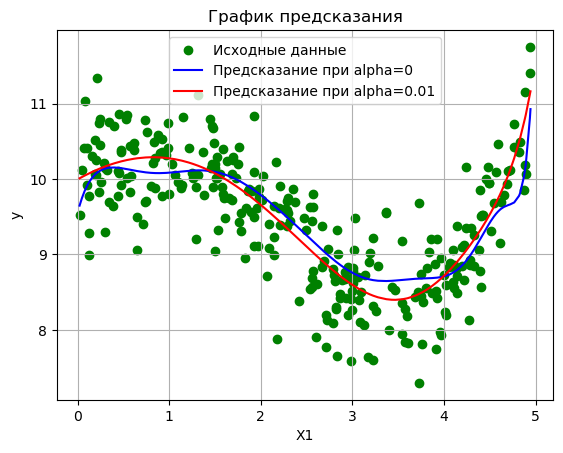

In [12]:
# Создаем выборку для отображения
X_1 = df['X1']

# Сортируем выборку 
sorted_indices = np.argsort(X_1)
X_1_sorted = X_1[sorted_indices]
X_sorted = X[sorted_indices]

# Отображаем график предсказания
plt.title('График предсказания')
plt.scatter(
    X_1, y,
    c='green', label='Исходные данные'
)
plt.plot(
    X_1_sorted, pipeline_0.predict(X_sorted),
    c='blue', label='Предсказание при alpha=0'
)
plt.plot(
    X_1_sorted, pipeline_001.predict(X_sorted),
    c='red', label='Предсказание при alpha=0.01'
)
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

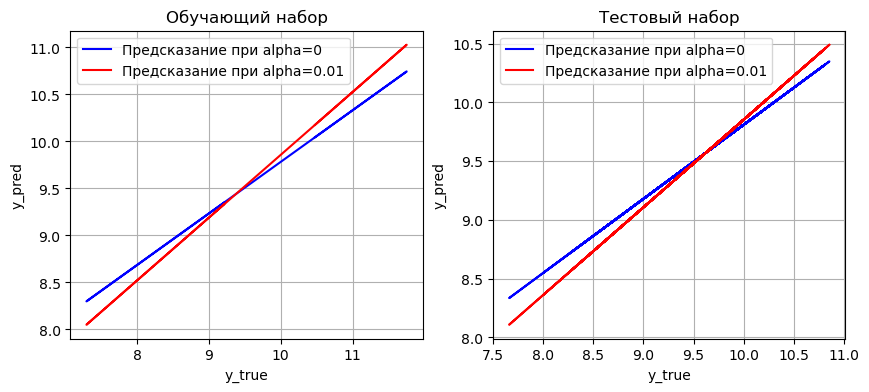

In [13]:
# Определяем функцию расчета параметра a
def calculate_slope(x, y):
    mx = x - x.mean()
    my = y - y.mean()
    return sum(mx * my) / sum(mx**2)


# Определяем функцию получения параметров a, b
def get_params(x, y):
    a = calculate_slope(x, y)
    b = y.mean() - a * x.mean()
    return a, b


# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = my_train_test_split(
    X, y,
    train_size=train_size,
    random_state=random_state
)

# Создаем графики
_, axs = plt.subplots(1, 2, figsize=(10, 4))

# Расчитываем параметры a, b обучающего набора
a_0, b_0 = get_params(y_train, pipeline_0.predict(X_train))
a_001, b_001 = get_params(y_train, pipeline_001.predict(X_train))

# Задаем настройки отображения графика обучающего набора
axs[0].plot(
    y_train, a_0*y_train + b_0,
    c='blue', label='Предсказание при alpha=0'
)
axs[0].plot(
    y_train, a_001*y_train + b_001,
    c='red', label='Предсказание при alpha=0.01'
)
axs[0].set_xlabel('y_true')
axs[0].set_ylabel('y_pred')
axs[0].set_title('Обучающий набор')
axs[0].legend()
axs[0].grid()

# Расчитываем параметры a, b тестового набора
a_0, b_0 = get_params(y_test, pipeline_0.predict(X_test))
a_001, b_001 = get_params(y_test, pipeline_001.predict(X_test))

# Задаем настройки отображения графика тестового набора
axs[1].plot(
    y_test, a_0*y_test + b_0,
    c='blue', label='Предсказание при alpha=0'
)
axs[1].plot(
    y_test, a_001*y_test + b_001,
    c='red', label='Предсказание при alpha=0.01'
)
axs[1].set_xlabel('y_true')
axs[1].set_ylabel('y_pred')
axs[1].set_title('Тестовый набор')
axs[1].legend()
axs[1].grid()

# Отображаем графики
plt.show()

## Задача 2. Классификация и кросс-валидация

In [14]:
# Подключаем необходимые библиотеки
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

# Игнорируем ошибки
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Создаем датафрейм и выводим его вершину
df = pd.read_csv(
    '../data/A2_Model_Selection/Cl_A5_V1.csv'
)
df.head()

,X1,X2,y
0,-0.192831,-0.489801,1.0
1,-0.776832,-0.221889,0.0
2,0.244302,0.309428,1.0
3,0.599050,-0.505053,1.0
4,1.124836,1.015005,0.0


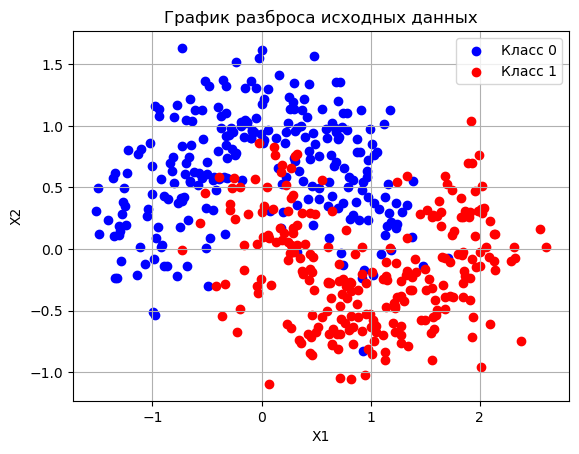

In [16]:
# Создаем матрицу признаков и вектор целевых значений
X = df[['X1', 'X2']].values
y = df['y'].values

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=0
)

# Отображаем график разброса исходных данных
plt.title('График разброса исходных данных')
plt.scatter(
    X[y == 0][:,0], X[y == 0][:,1],
    c='blue', label='Класс 0'
)
plt.scatter(
    X[y == 1][:,0], X[y == 1][:,1],
    c='red', label='Класс 1'
)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid()
plt.show()

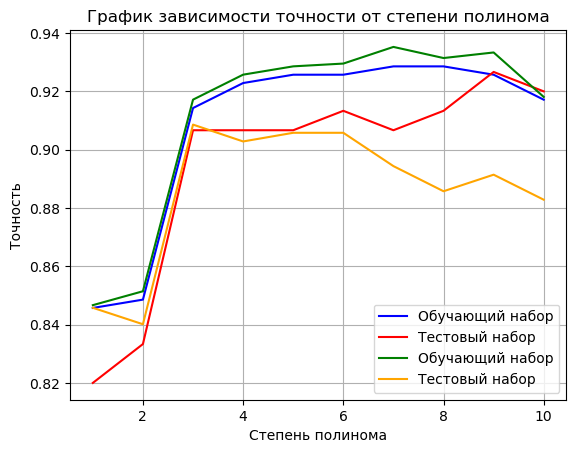

In [17]:
# Инициализируем списки для сохранения результатов обучения моделей
train_accs = []
test_accs = []
train_accs_cross = []
test_accs_cross = []

# Обучаем модели с разными степенями полиномов
degrees = range(1, 11)
for d in degrees:
    # Создаем полиномиальные признаки
    features = PolynomialFeatures(degree=d)
    X_train_features = features.fit_transform(X_train)
    X_test_features = features.transform(X_test)

    # Создаем и обучаем модель
    model = LogisticRegression(
        penalty='l2', fit_intercept=True,
        max_iter=100, C=1e5,
        solver='liblinear', random_state=12345
    )
    model.fit(X_train_features, y_train)

    # Вычисляем точность
    train_accs.append(
        accuracy_score(y_train, model.predict(X_train_features))
    )
    test_accs.append(
        accuracy_score(y_test, model.predict(X_test_features))
    )

    # Обучаем модель с кросс-валидацией
    cross_results = cross_validate(
        model, X_train_features, y_train,
        cv=4, return_train_score=True
    )

    # Вычисляем среднюю точность
    train_accs_cross.append(
        np.mean(cross_results['train_score'])
    )
    test_accs_cross.append(
        np.mean(cross_results['test_score'])
    )

# Отображаем график зависимости точности от степени полинома
plt.title('График зависимости точности от степени полинома')
plt.plot(
    degrees, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    degrees, test_accs,
    label='Тестовый набор', c='red'
)
plt.plot(
    degrees, train_accs_cross,
    label='Обучающий набор', c='green'
)
plt.plot(
    degrees, test_accs_cross,
    label='Тестовый набор', c='orange'
)
plt.xlabel('Степень полинома')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()

Как можно видеть из графика, на обучающей и тестовой выборках при увеличении степени полинома точность увеличивается. При использовании же более высоких степеней полинома точность начинает уменьшаться.

In [18]:
# Находим степень полинома с минимальной ошибкой
best_test_degree = degrees[np.argmax(test_accs)]
best_test_degree

9

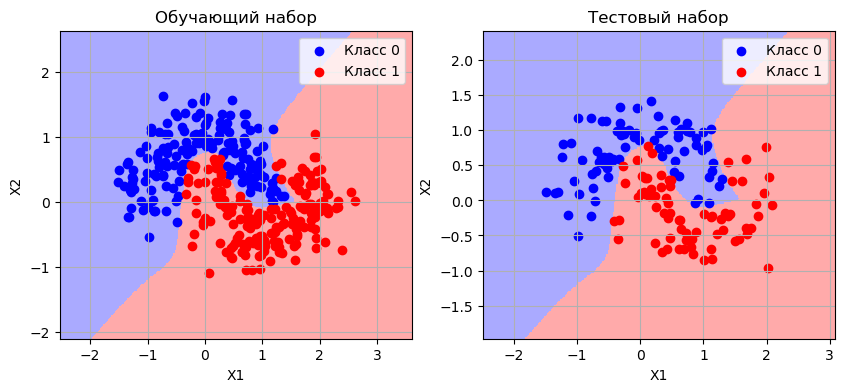

In [19]:
# Создаем полиномиальные признаки
features = PolynomialFeatures(degree=best_test_degree)
X_train_features = features.fit_transform(X_train)
X_test_features = features.transform(X_test)

# Создаем и обучаем модель
model = LogisticRegression(
    penalty='l2', fit_intercept=True,
    max_iter=100, C=1e5,
    solver='liblinear', random_state=12345
)
model.fit(X_train_features, y_train)

# Прогнозируем результаты
y_train_pred = model.predict(X_train_features)
y_test_pred = model.predict(X_test_features)

# Задаем цвет границы принятия решений
cmap=ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

# Создаем графики
_, axs = plt.subplots(1, 2, figsize=(10, 4))

# Задаем границы принятия решений обучающего набора
xx, yy = np.meshgrid(
    np.arange(
        X_train[:, 0].min() - 1,
        X_train[:, 0].max() + 1,
        .02
    ),
    np.arange(
        X_train[:, 1].min() - 1,
        X_train[:, 1].max() + 1,
        .02
    )
)
Z = model.predict(
    features.fit_transform(
        np.c_[xx.ravel(), yy.ravel()]
    )
).reshape(xx.shape)

# Задаем настройки отображения графика обучающего набора
axs[0].pcolormesh(xx, yy, Z, cmap=cmap)
axs[0].scatter(
    X_train[y_train_pred == 0][:, 0],
    X_train[y_train_pred == 0][:, 1],
    c='blue', label='Класс 0'
)
axs[0].scatter(
    X_train[y_train_pred == 1][:, 0],
    X_train[y_train_pred == 1][:, 1],
    c='red', label='Класс 1'
)
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
axs[0].set_title('Обучающий набор')
axs[0].legend()
axs[0].grid()

# Задаем границы принятия решений тестового набора
xx, yy = np.meshgrid(
    np.arange(
        X_test[:, 0].min() - 1,
        X_test[:, 0].max() + 1,
        .02
    ),
    np.arange(
        X_test[:, 1].min() - 1,
        X_test[:, 1].max() + 1,
        .02
    )
)
Z = model.predict(
    features.fit_transform(
        np.c_[xx.ravel(), yy.ravel()]
    )
).reshape(xx.shape)

# Задаем настройки отображения графика тестового набора
axs[1].pcolormesh(xx, yy, Z, cmap=cmap)
axs[1].scatter(
    X_test[y_test_pred == 0][:, 0],
    X_test[y_test_pred == 0][:, 1],
    c='blue', label='Класс 0'
)
axs[1].scatter(
    X_test[y_test_pred == 1][:, 0],
    X_test[y_test_pred == 1][:, 1],
    c='red', label='Класс 1'
)
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
axs[1].set_title('Тестовый набор')
axs[1].legend()
axs[1].grid()

# Отображаем графики
plt.show()

## Задача 3. Классификация текстовых документов

In [20]:
# Подключаем необходимые библиотеки
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import (
    balanced_accuracy_score, precision_score,
    recall_score, f1_score
)
import time

In [21]:
# Создаем датафрейм и выводим его вершину
df = pd.read_csv(
    '../data/A3_Text_Classification/SMSSpamCollection',
    sep='\t', header=None, names=['label', 'text']
)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
# Добавляем колонку со спамом
df['spam'] = df['label'].apply(
    lambda x: 1 if x == 'spam' else 0
)

# Создаем матрицу признаков и вектор целевых значений
X = df['text']
y = df['spam']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=123
)

# Определяем параметры моделей
neighbors_params = np.arange(1, 150, 20)
regression_params = np.logspace(-2, 10, 8, base=10)
smoothing_params = np.logspace(-4, 1, 8, base=10)

In [23]:
# Определяем функцию обучения произвольной модели
def fit_model(model, ngram_range):
    # Инициализируем списки для сохранения результатов
    train_accs = []
    test_accs = []
    
    # Обучаем модель через фолды
    kf = StratifiedKFold(
        n_splits=4, shuffle=True,
        random_state=123
    )
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Преобразуем текстовые данные с помощью TF-IDF
        vect = TfidfVectorizer(ngram_range=ngram_range)
        X_train_tfidf = vect.fit_transform(X_train)
        X_test_tfidf = vect.transform(X_test)

        # Обучаем модель
        model.fit(X_train_tfidf, y_train)

        # Прогнозируем результаты
        y_train_pred = model.predict(X_train_tfidf)
        y_test_pred = model.predict(X_test_tfidf)

        # Вычисляем точность
        train_accs.append(
            balanced_accuracy_score(y_train, y_train_pred)
        )
        test_accs.append(
            balanced_accuracy_score(y_test, y_test_pred)
        )
    
    return train_accs, test_accs


# Определяем функцию обучения модели K-ближайших соседей
def fit_neighbors(ngram_range):
    # Инициализируем списки для сохранения результатов
    train_accs = []
    test_accs = []

    # Обучаем модели с разными параметрами
    for n in neighbors_params:
        # Создаем и обучаем модель
        model = KNeighborsClassifier(n_neighbors=n)
        temp_train_accs, temp_test_accs = fit_model(model, ngram_range)
        
        # Сохраняем результаты
        train_accs.append(temp_train_accs)
        test_accs.append(temp_test_accs)
    
    # Фильтруем полученные значения 
    train_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], train_accs))
    test_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], test_accs))
    
    return train_accs_filtered, test_accs_filtered


# Определяем функцию обучения модели логистической регрессии
def fit_regression(ngram_range):
    # Инициализируем списки для сохранения результатов
    train_accs = []
    test_accs = []

    # Обучаем модели с разными параметрами
    for r in regression_params:
        # Создаем и обучаем модель
        model = LogisticRegression(C=r)
        temp_train_accs, temp_test_accs = fit_model(model, ngram_range)
        
        # Сохраняем результаты
        train_accs.append(temp_train_accs)
        test_accs.append(temp_test_accs)
    
    # Фильтруем полученные значения 
    train_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], train_accs))
    test_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], test_accs))
    
    return train_accs_filtered, test_accs_filtered


# Определяем функцию обучения модели Бернулли
def fit_bernoulli(ngram_range):
    # Инициализируем списки для сохранения результатов
    train_accs = []
    test_accs = []

    # Обучаем модели с разными параметрами
    for s in smoothing_params:
        # Создаем и обучаем модель
        model = BernoulliNB(alpha=s)
        temp_train_accs, temp_test_accs = fit_model(model, ngram_range)
        
        # Сохраняем результаты
        train_accs.append(temp_train_accs)
        test_accs.append(temp_test_accs)
    
    # Фильтруем полученные значения 
    train_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], train_accs))
    test_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], test_accs))
    
    return train_accs_filtered, test_accs_filtered


# Определяем функцию обучения полиномиальной модели
def fit_multinomial(ngram_range):
    # Инициализируем списки для сохранения результатов
    train_accs = []
    test_accs = []

    # Обучаем модели с разными параметрами
    for s in smoothing_params:
        # Создаем и обучаем модель
        model = MultinomialNB(alpha=s)
        temp_train_accs, temp_test_accs = fit_model(model, ngram_range)
        
        # Сохраняем результаты
        train_accs.append(temp_train_accs)
        test_accs.append(temp_test_accs)
    
    # Фильтруем полученные значения 
    train_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], train_accs))
    test_accs_filtered =\
        list(map(lambda x: x[len(x) - 1], test_accs))
    
    return train_accs_filtered, test_accs_filtered

### Для n-gram=1

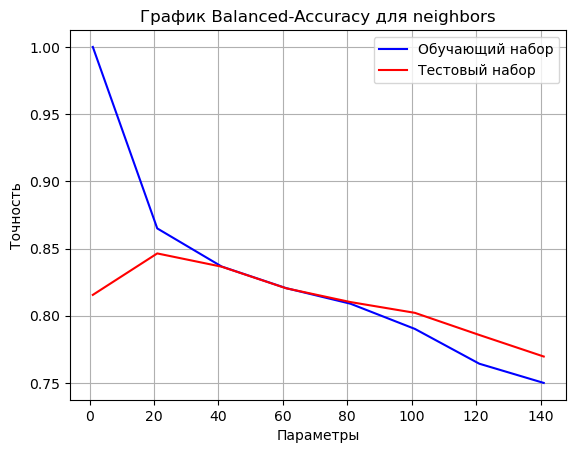

In [24]:
# Обучаем модель
train_accs, test_accs = fit_neighbors((1, 1))

# Находим параметры модели с минимальной ошибкой
best_neighbors_test_params_1 =\
    neighbors_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    neighbors_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    neighbors_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для neighbors')
plt.legend()
plt.grid()
plt.show()

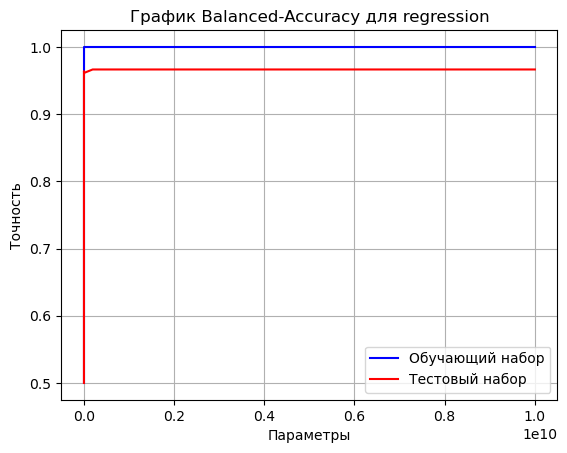

In [25]:
# Обучаем модель
train_accs, test_accs = fit_regression((1, 1))

# Находим параметры модели с минимальной ошибкой
best_regression_test_params_1 =\
    regression_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    regression_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    regression_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для regression')
plt.legend()
plt.grid()
plt.show()

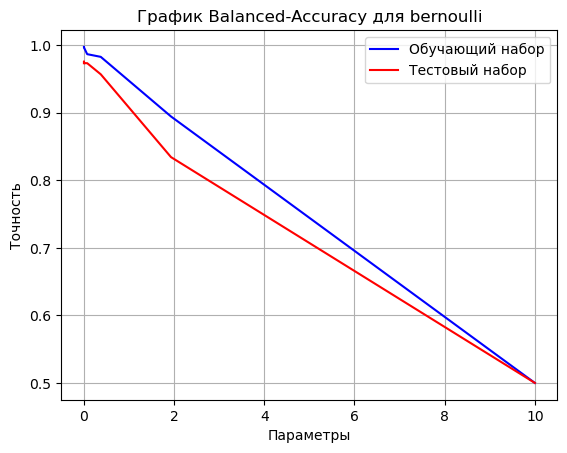

In [26]:
# Обучаем модель
train_accs, test_accs = fit_bernoulli((1, 1))

# Находим параметры модели с минимальной ошибкой
best_bernoulli_test_params_1 =\
    smoothing_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    smoothing_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    smoothing_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для bernoulli')
plt.legend()
plt.grid()
plt.show()

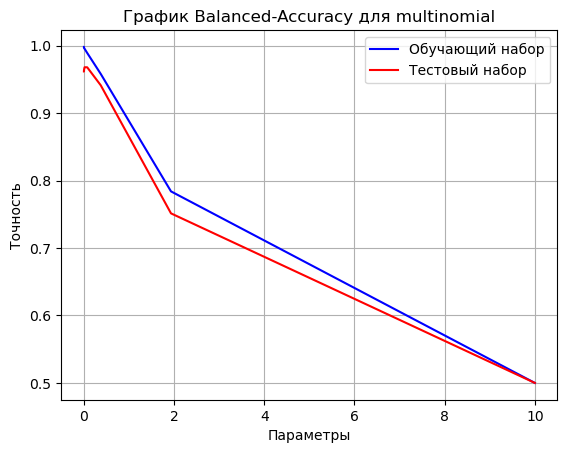

In [27]:
# Обучаем модель
train_accs, test_accs = fit_multinomial((1, 1))

# Находим параметры модели с минимальной ошибкой
best_multinomial_test_params_1 =\
    smoothing_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    smoothing_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    smoothing_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для multinomial')
plt.legend()
plt.grid()
plt.show()

### Для n-gram=2

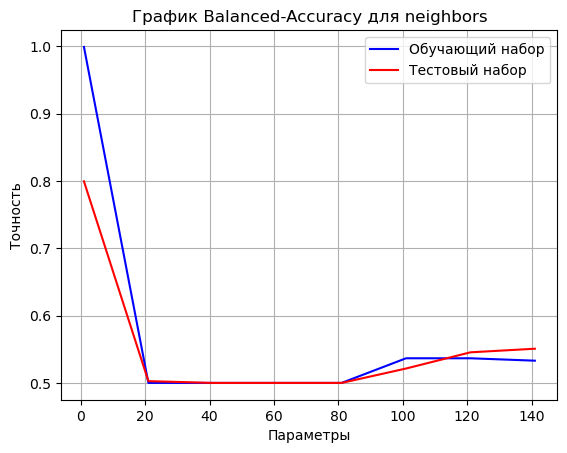

In [28]:
# Обучаем модель
train_accs, test_accs = fit_neighbors((2, 2))

# Находим параметры модели с минимальной ошибкой
best_neighbors_test_params_2 =\
    neighbors_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    neighbors_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    neighbors_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для neighbors')
plt.legend()
plt.grid()
plt.show()

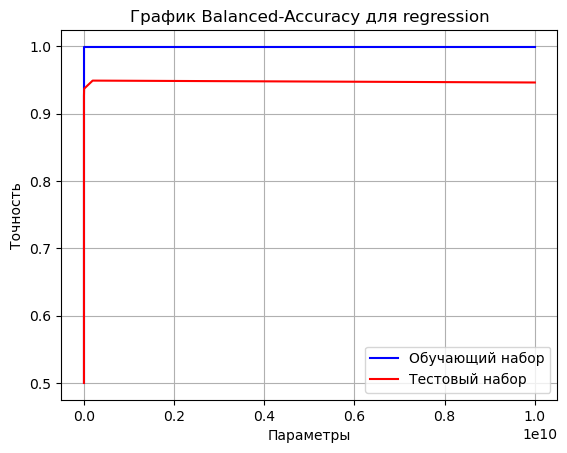

In [29]:
# Обучаем модель
train_accs, test_accs = fit_regression((2, 2))

# Находим параметры модели с минимальной ошибкой
best_regression_test_params_2 =\
    regression_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    regression_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    regression_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для regression')
plt.legend()
plt.grid()
plt.show()

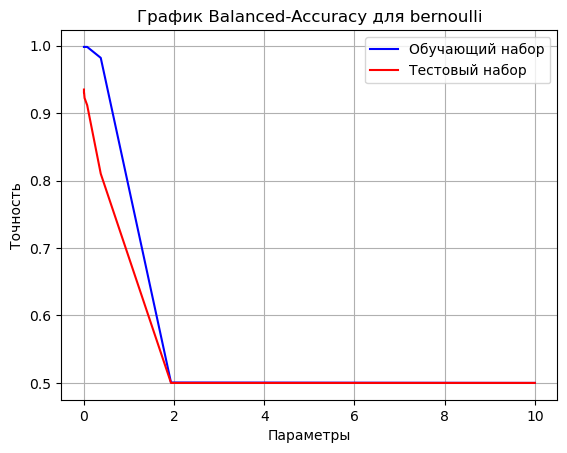

In [30]:
# Обучаем модель
train_accs, test_accs = fit_bernoulli((2, 2))

# Находим параметры модели с минимальной ошибкой
best_bernoulli_test_params_2 =\
    smoothing_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    smoothing_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    smoothing_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для bernoulli')
plt.legend()
plt.grid()
plt.show()

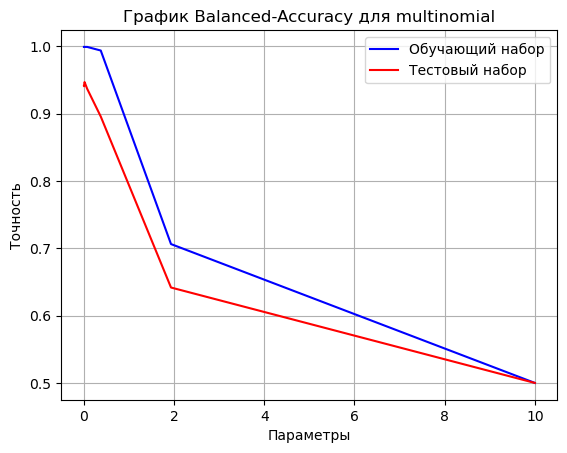

In [31]:
# Обучаем модель
train_accs, test_accs = fit_multinomial((2, 2))

# Находим параметры модели с минимальной ошибкой
best_multinomial_test_params_2 =\
    smoothing_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    smoothing_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    smoothing_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для multinomial')
plt.legend()
plt.grid()
plt.show()

### Для n-gram=(1, 2)

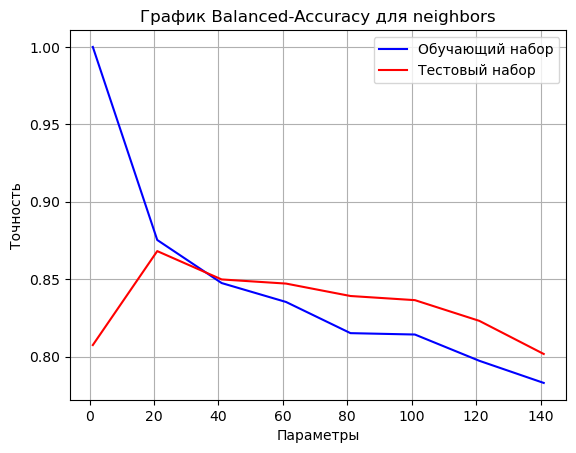

In [32]:
# Обучаем модель
train_accs, test_accs = fit_neighbors((1, 2))

# Находим параметры модели с минимальной ошибкой
best_neighbors_test_params_1_2 =\
    neighbors_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    neighbors_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    neighbors_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для neighbors')
plt.legend()
plt.grid()
plt.show()

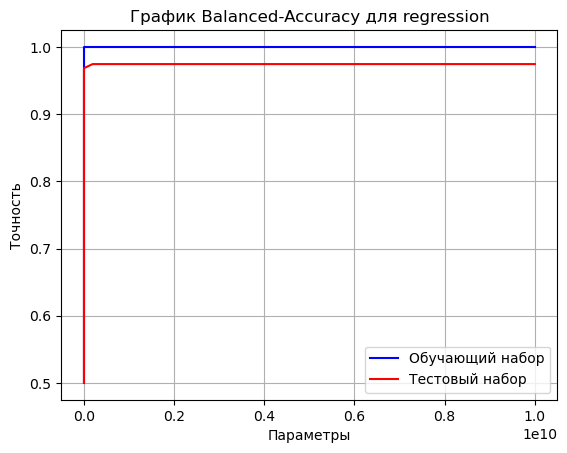

In [33]:
# Обучаем модель
train_accs, test_accs = fit_regression((1, 2))

# Находим параметры модели с минимальной ошибкой
best_regression_test_params_1_2 =\
    regression_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    regression_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    regression_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для regression')
plt.legend()
plt.grid()
plt.show()

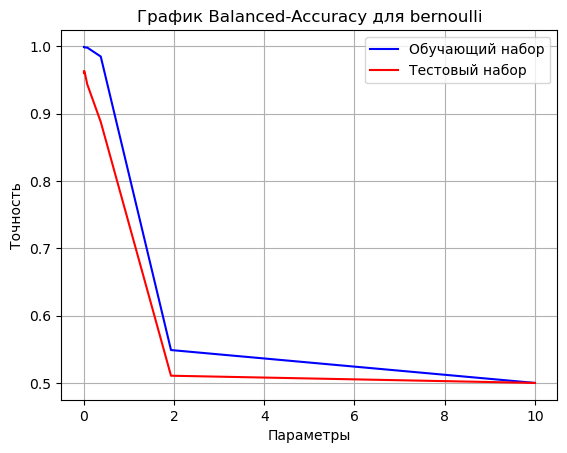

In [34]:
# Обучаем модель
train_accs, test_accs = fit_bernoulli((1, 2))

# Находим параметры модели с минимальной ошибкой
best_bernoulli_test_params_1_2 =\
    smoothing_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    smoothing_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    smoothing_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для bernoulli')
plt.legend()
plt.grid()
plt.show()

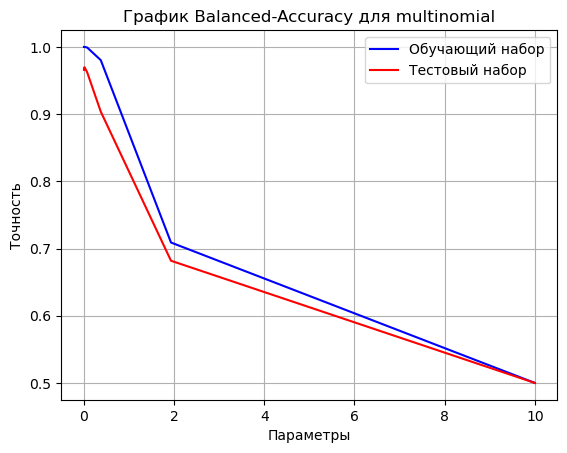

In [35]:
# Обучаем модель
train_accs, test_accs = fit_multinomial((1, 2))

# Находим параметры модели с минимальной ошибкой
best_multinomial_test_params_1_2 =\
    smoothing_params[np.argmax(test_accs)]

# Строим график Balanced-Accuracy
plt.plot(
    smoothing_params, train_accs,
    label='Обучающий набор', c='blue'
)
plt.plot(
    smoothing_params, test_accs,
    label='Тестовый набор', c='red'
)
plt.xlabel('Параметры')
plt.ylabel('Точность')
plt.title('График Balanced-Accuracy для multinomial')
plt.legend()
plt.grid()
plt.show()

In [36]:
# Определяем функцию получения данных об моделе с минимальной ошибкой
def get_model_info(obj):
    # Получаем данные из объекта
    model = obj['model']
    ngram_range = obj['ngram_range']
    method = obj['method']
    params = obj['params']
    
    # Преобразуем текстовые данные с помощью TF-IDF
    vect = TfidfVectorizer(ngram_range=ngram_range)
    X_train_tfidf = vect.fit_transform(X_train)
    X_test_tfidf = vect.transform(X_test)

    # Меряем время обучения
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time

    # Меряем время предсказания
    start_time = time.time()
    y_test_pred = model.predict(X_test_tfidf)
    prediction_time = time.time() - start_time
    
    return [
        method, ngram_range, params,
        training_time, prediction_time,
        balanced_accuracy_score(
            y_test, y_test_pred
        ),
        recall_score(
            y_test, y_test_pred
        ),
        precision_score(
            y_test, y_test_pred
        ),
        f1_score(
            y_test, y_test_pred
        )
    ]

# Создаем таблицу с результатами
results = []
columns = [
    'Метод', 'n-gram', 'Параметры', 
    'Время обучения', 'Время предсказания',
    'Balanced-Accuracy', 'R', 'P', 'F1'
]

# Для n-gram=1
results += map(get_model_info, [
    {
        'model': KNeighborsClassifier(
            n_neighbors=best_neighbors_test_params_1
        ),
        'ngram_range': (1, 1),
        'method': 'neighbors',
        'params': best_neighbors_test_params_1
    },
    {
        'model': LogisticRegression(
            C=best_regression_test_params_1
        ),
        'ngram_range': (1, 1),
        'method': 'regression',
        'params': best_regression_test_params_1
    },
    {
        'model': BernoulliNB(
            alpha=best_bernoulli_test_params_1
        ),
        'ngram_range': (1, 1),
        'method': 'bernoulli',
        'params': best_bernoulli_test_params_1
    },
    {
        'model': MultinomialNB(
            alpha=best_multinomial_test_params_1
        ),
        'ngram_range': (1, 1),
        'method': 'multinomial',
        'params': best_multinomial_test_params_1
    }
])

# Для n-gram=2
results += map(get_model_info, [
    {
        'model': KNeighborsClassifier(
            n_neighbors=best_neighbors_test_params_2
        ),
        'ngram_range': (2, 2),
        'method': 'neighbors',
        'params': best_neighbors_test_params_2
    },
    {
        'model': LogisticRegression(
            C=best_regression_test_params_2
        ),
        'ngram_range': (2, 2),
        'method': 'regression',
        'params': best_regression_test_params_2
    },
    {
        'model': BernoulliNB(
            alpha=best_bernoulli_test_params_2
        ),
        'ngram_range': (2, 2),
        'method': 'bernoulli',
        'params': best_bernoulli_test_params_2
    },
    {
        'model': MultinomialNB(
            alpha=best_multinomial_test_params_2
        ),
        'ngram_range': (2, 2),
        'method': 'multinomial',
        'params': best_multinomial_test_params_2
    }
])

# Для n-gram=(1, 2)
results += map(get_model_info, [
    {
        'model': KNeighborsClassifier(
            n_neighbors=best_neighbors_test_params_1_2
        ),
        'ngram_range': (1, 2),
        'method': 'neighbors',
        'params': best_neighbors_test_params_1_2
    },
    {
        'model': LogisticRegression(
            C=best_regression_test_params_1
        ),
        'ngram_range': (1, 2),
        'method': 'regression',
        'params': best_regression_test_params_1_2
    },
    {
        'model': BernoulliNB(
            alpha=best_bernoulli_test_params_1_2
        ),
        'ngram_range': (1, 2),
        'method': 'bernoulli',
        'params': best_bernoulli_test_params_1_2
    },
    {
        'model': MultinomialNB(
            alpha=best_multinomial_test_params_1_2
        ),
        'ngram_range': (1, 2),
        'method': 'multinomial',
        'params': best_multinomial_test_params_1_2
    }
])

# Отображаем таблицу с результатами
pd.DataFrame(results, columns=columns)

,Метод,n-gram,Параметры,Время обучения,Время предсказания,Balanced-Accuracy,R,P,F1
0,neighbors,"(1, 1)",2.100000e+01,0.004744,0.621101,0.871510,0.745098,0.982759,0.847584
1,regression,"(1, 1)",1.930698e+08,0.435082,0.000600,0.964202,0.934641,0.959732,0.947020
2,bernoulli,"(1, 1)",5.179475e-04,0.013121,0.005820,0.960265,0.921569,0.992958,0.955932
3,multinomial,"(1, 1)",1.389495e-02,0.009022,0.001042,0.956997,0.915033,0.992908,0.952381
4,neighbors,"(2, 2)",1.000000e+00,0.004571,0.429447,0.781046,0.562092,1.000000,0.719665
5,regression,"(2, 2)",1.930698e+08,2.067647,0.000540,0.934348,0.901961,0.811765,0.854489
6,bernoulli,"(2, 2)",1.000000e-04,0.021763,0.018283,0.920009,0.843137,0.977273,0.905263
7,multinomial,"(2, 2)",1.389495e-02,0.016797,0.002103,0.921718,0.849673,0.955882,0.899654
8,neighbors,"(1, 2)",2.100000e+01,0.007077,0.598151,0.891117,0.784314,0.983607,0.872727
9,regression,"(1, 2)",1.930698e+08,1.869939,0.000705,0.966950,0.941176,0.953642,0.947368


Как можно видеть из таблицы, данные методы обладают следующими преимуществами и недостатками:
1. K-ближайших соседей.

 а) Преимущества: низкое время обучения, высокий показатель P.

 б) Недостатки: высокое время предсказания, низкие показатели Balanced-Accuracy, R и F1.


2. Логистическая регрессия.

 а) Преимущества: низкое время предсказания, высокие показатели Balanced-Accuracy и R.

 б) Недостатки: высокое время обучения.


3. Наивный Байес с параметром модели Бернулли.

 а) Преимущества: низкое время обучения и предсказания, высокие показатели Balanced-Accuracy и P.

 б) Недостатки: низкий показатель R при n-gram=2 и n-gram=(1, 2).


4. Наивный Байес с параметром полиномиальной модели.

 а) Преимущества: низкое время обучения и предсказания, высокие показатели Balanced-Accuracy и P.

 б) Недостатки: низкий показатель R при n-gram=2.

## Вывод

В ходе выполнения домашнего задания был приобретен опыт решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания, посредством языка программирования Python.